<a href="https://colab.research.google.com/github/DonnaVakalis/Livability/blob/master/Your_Liveability_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>Where to Live? A personalizeable 'livability' assessment dashboard</center></h1>

The portion of employees able to work remotely is increasing, resulting in decoupling a company’s geographic location from worker’s choice of where to live. This opens up the possibility to choose where to live based on other metrics, such as local air quality, affordability, proximity to family, ‘good’ weather.

Existing livability indices (e.g., https://en.wikipedia.org/wiki/Global_Liveability_Ranking) are useful, in a generic way, yet they are not customizable. This project will aggregate conventional livability metrics with personal preference inputs, such as weather preference and proximity to other cities (e.g., friends and family) into an online dashboard for anyone to search for their best place to live.

For ~600 cities: latitude/longitude, population density, consumer price index, average particulate matter concentrations (PM 2.5) as a proxy for air quality, duration of shortest travel to other cities in the list;  renting affordability index; frequency of mention of city name in proximity to certain keywords related to specific activities {to start: surfing, hiking} on social media. 
In the data some cities are better represented than others, and so the reconciling will mean either having fewer cities participate. To date, my initial exploration has yielded some datasets with as few as 32 cities, however manually searching for some data may increase that minimum.



## 0. Setup



In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

## 1. Import and read in data for cities



In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from google.colab import drive
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px


In [4]:
# mount google drive
drive.mount('/content/gdrive/')

root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'liveability/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
# Read in data

# 1. Read Countries --> Geopackage Format
file = base_dir + 'countries.gpkg'
countries = gpd.read_file(file)

# 2. Read State Codes --> CSV file
df_codes=pd.read_csv("https://danieljwilson.com/datasets/min_wage/USPS_two_letter_state.csv", encoding= 'unicode_escape')

# 3. Read Cities --> Geojson Format
file = base_dir + 'cities.geojson'
cities = gpd.read_file(file)

# 4. Read Air Quality --> 


# 5. Read Minimum Wage data --> CSV file 
df_min=pd.read_csv("https://danieljwilson.com/datasets/min_wage/min_wage_usa_2020.csv", encoding= 'ISO-8859-1')



##Data Provenance
Public Datasets Used:

World bank Environment,Social And Governance Data Catalogue
[NOA GLobal] (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v4) 

Historical Climatology v4 data
[World Health Organization] (https://apps.who.int/gho/data/node.home) 

Datasets for ambient air pollution, road safety and health coverage
from IMF Global Housing Data

Expanded Project Datasets (for inclusion later on):

*The Economist EIU’s liveability ratings for 140 cities around the world. Note this dataset requires a paid subscription
*The USA Livability website

In [ ]:
cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7343 entries, 0 to 7342
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   name       7343 non-null   object  
 1   worldcity  7343 non-null   float64 
 2   megacity   7343 non-null   int64   
 3   latitude   7343 non-null   float64 
 4   longitude  7343 non-null   float64 
 5   pop_max    7343 non-null   int64   
 6   pop_min    7343 non-null   int64   
 7   pop_other  7343 non-null   int64   
 8   geometry   7343 non-null   geometry
dtypes: float64(3), geometry(1), int64(4), object(1)
memory usage: 516.4+ KB


In [ ]:
# There are 7343 Cities in this dataset
# Let's only look at 'World Cities' (70) and 'Mega Cities' (590) to start...
cities_filtered = cities.query('megacity == 1.0 or worldcity == 1.0')
cities_filtered.info() #now 594 cities :)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 594 entries, 880 to 7342
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   name       594 non-null    object  
 1   worldcity  594 non-null    float64 
 2   megacity   594 non-null    int64   
 3   latitude   594 non-null    float64 
 4   longitude  594 non-null    float64 
 5   pop_max    594 non-null    int64   
 6   pop_min    594 non-null    int64   
 7   pop_other  594 non-null    int64   
 8   geometry   594 non-null    geometry
dtypes: float64(3), geometry(1), int64(4), object(1)
memory usage: 46.4+ KB


In [ ]:
cities_filtered.head()

,name,worldcity,megacity,latitude,longitude,pop_max,pop_min,pop_other,geometry,pop_average,pop_rel
880,Vatican City,1.0,0,41.900012,12.447808,832,832,562430,POINT (12.45339 41.90328),832.0,0.000023
2699,Ad Damman,0.0,1,26.428192,50.099670,2054710,768602,943243,POINT (50.09772 26.43014),1411656.0,0.039570
3191,Toluca,0.0,1,19.330382,-99.669999,1531000,505881,1440686,POINT (-99.67195 19.33233),1018440.5,0.028548
3683,Zigong,0.0,1,29.400000,104.780002,1105000,689961,3479038,POINT (104.77806 29.40195),897480.5,0.025157
3693,Baoding,0.0,1,38.870430,115.480021,1107000,995652,4801264,POINT (115.47807 38.87238),1051326.0,0.029469


In [ ]:
# Check CRS
cities_filtered.crs #EPSG:4326
countries.crs #EPSG:4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

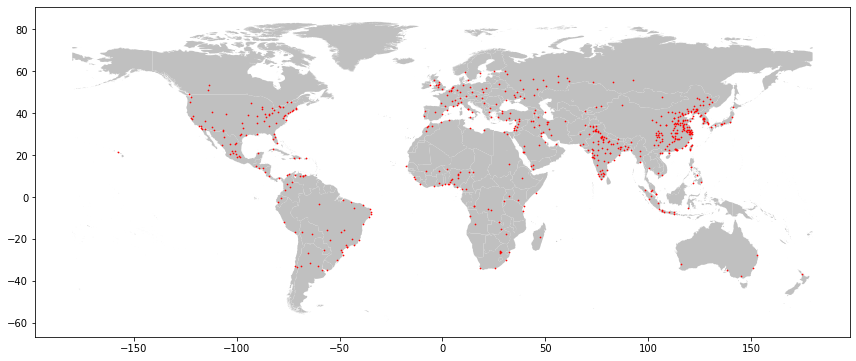

In [ ]:
# Plot maps
fig, ax = plt.subplots(figsize=(12,12))
countries.plot(ax=ax, color='silver')
cities_filtered.plot(markersize=0.5, color='red',ax=ax)
plt.tight_layout()
plt.savefig('overlay_map.png')
plt.show()

## 2. Air Pollution and Other TBD

Layer on liveablity data associate with cities...


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



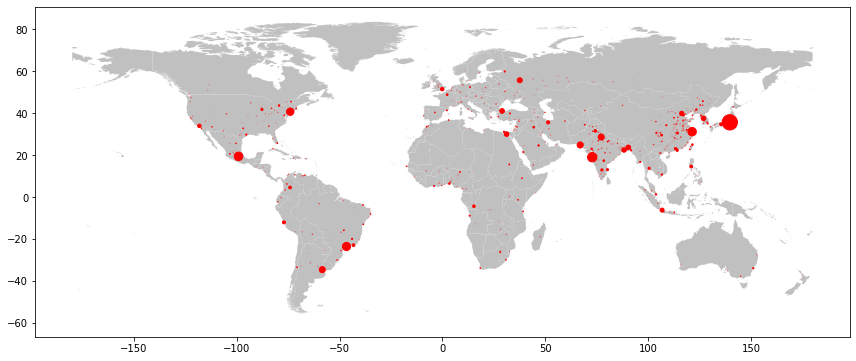

In [ ]:
# Vary Marker Size by Population
MAX= cities_filtered.pop_max.max() 
MIN= cities_filtered.pop_min.min()
DIFF= MAX-MIN
cities_filtered['pop_average'] = cities_filtered.apply(lambda row: row.pop_max/2 + row.pop_min/2, axis=1)
cities_filtered['pop_rel'] = cities_filtered.apply(lambda row: row.pop_average / DIFF, axis=1)
cities_filtered.head()

marker_size = cities_filtered['pop_rel']

fig, ax = plt.subplots(figsize=(12,12))
countries.plot(ax=ax, color='silver')
cities_filtered.plot(markersize= (marker_size*10)**3, color='red',ax=ax)
plt.tight_layout()
plt.savefig('overlay_map.png')
plt.show()


In [ ]:
# Using USPS state codes because Plotly will automatically associate these specific abbreviations with location on the map
df_min = pd.merge(df_min,  df_codes, on='State',how='left') 

In [7]:
fig = px.choropleth(df_min,   
                    locations="Abbreviation",  # DataFrame column with locations
                    color="Wage",  # DataFrame column with color values
                    hover_name="State", # DataFrame column hover info
                    locationmode = 'USA-states', # Set to plot as US States
                    color_continuous_scale= px.colors.sequential.RdBu) # Colour palette
fig.update_layout(
    title_text = 'Minimum Wage by State, 2020', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen


ValueError: ignored

In [ ]:
# Data
countries.head()


,NAME,POP_EST,POP_RANK,GDP_MD_EST,POP_YEAR,LASTCENSUS,GDP_YEAR,ECONOMY,INCOME_GRP,CONTINENT,geometry
0,Indonesia,260580739,17,3028000.0,2017,2010,2016,4. Emerging region: MIKT,4. Lower middle income,Asia,(POLYGON ((117.7036079039552 4.163414542001791...
1,Malaysia,31381992,15,863000.0,2017,2010,2016,6. Developing region,3. Upper middle income,Asia,(POLYGON ((117.7036079039552 4.163414542001791...
2,Chile,17789267,14,436100.0,2017,2002,2016,5. Emerging region: G20,3. Upper middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...
3,Bolivia,11138234,14,78350.0,2017,2001,2016,5. Emerging region: G20,4. Lower middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...
4,Peru,31036656,15,410400.0,2017,2007,2016,5. Emerging region: G20,3. Upper middle income,South America,(POLYGON ((-69.51008875199994 -17.506588197999...


## Another layer...


